# Rationale behind a model being a baseline model

1. No trajectory or sequence of steps awareness
2. No timeline awareness
3. Memory-less
4. Assume stable and general trajectory for users and at all time

# Import Data

In [1]:
import random
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from collections import Counter
from torch.utils.data import Dataset

In [2]:
df_train = pd.read_csv('df_train_1k.csv')
df_test = pd.read_csv('df_test_1k.csv')

In [3]:
# Group data by uid
grouped_data_train = [group for _, group in df_train.groupby('uid')]
grouped_data_test = [group for _, group in df_test.groupby('uid')]

STEP_SIZE = 100
WINDOW_SIZE = 10

class TrajectoryDataset(Dataset):
    def __init__(self, grouped_data):
        self.data = []
        for group in grouped_data:
            if len(group) >= STEP_SIZE:
                
                # Get the first STEP_SIZE location and time data
                xy = group['combined_xy'].values.tolist()[:STEP_SIZE]
                t = group['t'].values.tolist()[:STEP_SIZE]
                
                # Slice the data into several sessions using moving window approach
                self.data.extend([(xy[i:i+WINDOW_SIZE], t[i:i+WINDOW_SIZE]) 
                                  for i in range(0, STEP_SIZE-WINDOW_SIZE+1, WINDOW_SIZE)])
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        xy_window, t_window = self.data[idx]
        inputs = torch.tensor(xy_window[:-1])        # input sequence of locations
        labels = torch.tensor(xy_window[-1])         # desired predicted location
        positions = torch.tensor(t_window[:-1])      # corresponding input locations' times
        label_positions = torch.tensor(t_window[-1]) # corresponding predicted location's time
        
        return inputs, labels, positions, label_positions

train_dataset = TrajectoryDataset(grouped_data_train)
test_dataset  = TrajectoryDataset(grouped_data_test)

# Inference

In [11]:
total_correct = 0

for inputs, labels, positions, label_positions in test_dataset:
    total_correct += int(labels.item() == most_freq_locs[label_positions.item()])
    
print(f"Accuracy: {total_correct/test_dataset.__len__()}, Num Correct: {total_correct}, Num Sample: {test_dataset.__len__()}")

Accuracy: 0.0025, Num Correct: 5, Num Sample: 2000


# Visualization

In [12]:
frequent_locations = [(152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (178, 34), (125, 137), (158, 64), (125, 137), (152, 95), (130, 63), (129, 81), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (152, 95), (152, 95), (152, 95)]

In [19]:
# extract correct or incorrect prediction for visualization
def extract_prediction(dataloader, extract_correct=True):
        for inputs, labels, positions, label_positions in dataloader:
            actual = labels.item()
            prediction = most_freq_locs[label_positions.item()]
            if (extract_correct):
                if (actual == prediction):
                    return inputs.tolist(), \
                            labels.item(), \
                            positions.tolist(), \
                            label_positions.item(), \
                            prediction
            else:
                if (actual != prediction):
                    return inputs.tolist(), \
                            labels.item(), \
                            positions.tolist(), \
                            label_positions.item(), \
                            prediction

In [20]:
def plot_trajectory(inputs, labels, positions, label_positions, prediction, display_frequent=True): 
    """
    inputs: List<int>: trajctory of a user; a list of location-id a user has stepped through
    labels: int: the desired location-id or the label of the model prediction
    positions: List<int>: corresponding time recorded in each of the trajectory data above
    label_positions: int: corresponding time of the recorded label location-id
    prediction: int: the predicted location-id made by the model
    display_frequent: boolean: whether or not to display the most frequently visited location
    """
    
    # Determine if the prediction is correct
    false_prediction = True
    if (prediction == labels): 
        false_prediction = False
        
    fig, ax = plt.subplots(figsize=(5,5))
    
    # Plot the trajectory (blue line)
    inputs = df_train[df_train['combined_xy'].isin(inputs)] # def
    ys = list(inputs['y'])
    xs = list(inputs['x'])
    ax.plot(xs, ys, label='Trajectory', linewidth=0.5)
    ax.scatter(xs, ys)
    
    # # Trajectory Time Annotation
    # for i in range(len(positions)):
        # ax.annotate(str(positions[i]), (inputs.iloc[i]['x'], inputs.iloc[i]['y']), 
        # textcoords="offset points", xytext=(0,10), ha='center')
    
    # Plot label (green dot)
    df_train_labels = df_train[df_train['combined_xy']==labels].iloc[0] # def
    labels = (df_train_labels['x'], df_train_labels['y'])
    ax.plot(*labels,'go', label='Actual Location') 
    
    # # Label Time Annotation
    # ax.annotate(str(label_positions), labels, textcoords="offset points", 
    # xytext=(0,10), ha='center')

    # If false prediction: plot predicted location (red dot)
    if false_prediction:
        df_train_prediction = df_train[df_train['combined_xy']==prediction].iloc[0] # def
        prediction = (df_train_prediction['x'], df_train_prediction['y'])
        ax.plot(*prediction, 'ro', label='Predicted Location')
    
    # If request display_requent: plot frequently visited location (purple dot)
    if display_frequent:
        frequent = frequent_locations[label_positions]
        ax.plot(*frequent, 'mo', label='Frequent Location')
    
    # # Setting up the legend and labels
    # ax.set_xlim(0, 200)
    # ax.set_ylim(0, 200)
    # ax.set_xticks(range(0, 201, 1))
    # ax.set_yticks(range(0, 201, 1))
    ax.grid(True)
    ax.set_xlabel('X-Coordinate')
    ax.set_ylabel('Y-Coordinate')
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

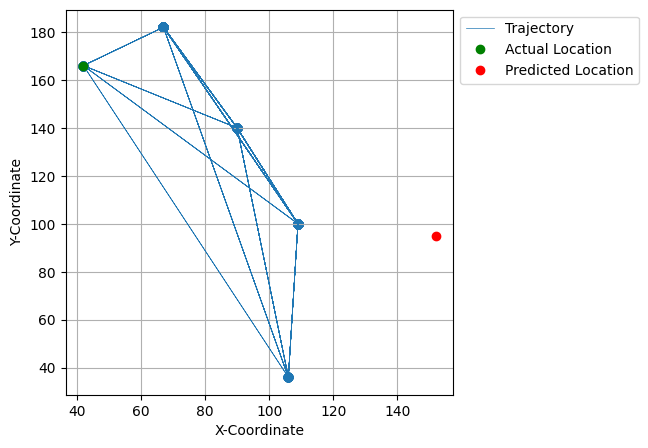

In [23]:
inputs,labels,positions,label_positions,prediction = extract_prediction(test_dataset,False)
plot_trajectory(inputs,labels,positions,label_positions,prediction,False)

**Frequency**

```
most_frequent_locs = [18951, 18951, 18951, 18951, 18951, 18951, 18951, 18951, 6777, 27324, 12757, 27324, 18951, 12529, 16128, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 15334, 18951, 18951, 18951]
                      
frequent_locations = []
for l in most_frequent_locs:
    loc = df_train[df_train['combined_xy']==l].iloc[0]
    frequent_locations.append((loc['x'],loc['y']))

frequent_locations = [(152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (152, 95), (178, 34), (125, 137), (158, 64), (125, 137), (152, 95), (130, 63), (129, 81), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (135, 77), (152, 95), (152, 95), (152, 95)]
```